### Rolling predictions 

Comparing results on scikit tree & forest, prophet, SARIMA and craft on energy time series

We start by feeding the model 2 months of data, and ask them to predict 1 week

In [1]:
import pandas as pd
import numpy as np
import subprocess
import json
import benchmark_tools as bt
import pickle
import os
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

In [12]:
palette = sns.color_palette("Set2", 10, 0.9)
sns.set_palette(palette)
sns.set_style("dark")
import imp
imp.reload(bt)
os.getcwd()

'C:\\Users\\Claire\\Documents\\craft-ai-kit-energy\\benchmark'

In [13]:
import logging
import warnings
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [54]:
week_unit = 7*24*2
week_offset = 50
start_index = week_offset * week_unit
start_pred_index = start_index + 2*52*week_unit
data = pd.read_csv('data/uci/uci_30T.csv', parse_dates=['date'])

#Remove the first year to let only the last 3 years for predictions
data = data.iloc[start_index-1:]
# Getting rid of nan values
data.index = pd.to_datetime(data.date)
data = data.dropna().drop('date',1)
print('Cleaned dataset: {:d} rows, {:d} columns'.format(data.shape[0],data.shape[1]))
print('Types of data: \n{}'.format(data.dtypes))

Cleaned dataset: 35578 rows, 1 columns
Types of data: 
load    float64
dtype: object


In [55]:
data.head()

,load
date,
2008-11-15 16:30:00,2208.0
2008-11-15 17:00:00,4960.0
2008-11-15 17:30:00,3518.0
2008-11-15 18:00:00,3764.0
2008-11-15 18:30:00,4004.0


In [60]:
week_unit = 7*24*2
start_index = 0
start_pred_index = start_index + 2*52*week_unit
data = pd.read_csv('data/uci/uci_30T.csv', parse_dates=['date'])

#Remove the first year to let only the last 3 years for predictions
# Getting rid of nan values
data.index = pd.to_datetime(data.date)
data = data.dropna().drop('date',1)
print('Cleaned dataset: {:d} rows, {:d} columns'.format(data.shape[0],data.shape[1]))
print('Types of data: \n{}'.format(data.dtypes))

#Adding temperature information
temp = pd.read_json('provider/weather_cache_uci.json', convert_dates=['date'])
temp['date'] = temp.iloc[:,0].str.extract(r'[\d]+\.[\d]+,[\d]+\.[\d]+,([\d]+)')
temp['temperatureLow'] = temp.iloc[:,1].apply(lambda x : x['temperatureLow'])
temp['temperatureHigh'] = temp.iloc[:,1].apply(lambda x : x['temperatureHigh'])
temp.index = pd.to_datetime(temp.date, unit='s')
temp = temp.sort_index()
temp = temp.drop([0,1,'date'],1)

data = data.merge(temp, how='left', left_index=True, right_index=True)

Cleaned dataset: 52377 rows, 1 columns
Types of data: 
load    float64
dtype: object


In [61]:
data.head()

,load,temperatureLow,temperatureHigh
date,,,
2007-12-01 17:00:00,2724.0,7.84,10.56
2007-12-01 17:30:00,2706.0,NaN,NaN
2007-12-01 18:00:00,3880.0,NaN,NaN
2007-12-01 18:30:00,2798.0,NaN,NaN
2007-12-01 19:00:00,3436.0,NaN,NaN


In [62]:
data = data.fillna(method='ffill')
data = data[1:] #Adapt to fit with rolling craft preds

In [63]:
data.index.values[0], data.index.values[-1]

(numpy.datetime64('2007-12-01T17:30:00.000000000'),
 numpy.datetime64('2010-11-26T21:00:00.000000000'))

In [64]:
print('{} semaines dans les données'.format(round((data.index[-1] - data.index[0]).days/7,2)))

155.86 semaines dans les données


In [65]:
data.head()

,load,temperatureLow,temperatureHigh
date,,,
2007-12-01 17:30:00,2706.0,7.84,10.56
2007-12-01 18:00:00,3880.0,7.84,10.56
2007-12-01 18:30:00,2798.0,7.84,10.56
2007-12-01 19:00:00,3436.0,7.84,10.56
2007-12-01 19:30:00,1890.0,7.84,10.56


In [66]:
data.tail()

,load,temperatureLow,temperatureHigh
date,,,
2010-11-26 19:00:00,1810.0,-0.93,3.14
2010-11-26 19:30:00,1908.0,-0.93,3.14
2010-11-26 20:00:00,1456.0,-0.93,3.14
2010-11-26 20:30:00,980.0,-0.93,3.14
2010-11-26 21:00:00,938.0,-0.93,3.14


In [50]:
week_index =  int(start_pred_index/week_unit) - week_offset# let's start the rolling preds for the last year
max_week_index = int(data.shape[0]/week_unit)

idx = ['scikit tree', 'scikit forest', 'prophet']
scores = []
all_preds = []
# max_week_index
last_train_index = week_index * week_unit
last_test_index = (week_index +1) * week_unit
week_preds = {}

data_train, data_test = bt.split_data(data, last_train_index-1 , last_test_index-1)

#limit to one year of data to avoid memory error
for i in range(1,42,10):
    print('computing prophet with {} weeks in the training data'.format(i))
    %time bt.get_prophet_preds(data_train, data_test, exog = ['temperatureLow', 'temperatureHigh'], max_feed = i*week_unit)

computing prophet with 1 weeks in the training data
Wall time: 42.9 s
computing prophet with 11 weeks in the training data
Wall time: 4min 13s
computing prophet with 21 weeks in the training data
Wall time: 10min 38s
computing prophet with 31 weeks in the training data
Wall time: 12min 42s
computing prophet with 41 weeks in the training data
Wall time: 14min 20s


In [11]:
data.head()

,load,temperatureLow,temperatureHigh
date,,,
2007-12-01 17:24:00,2724.0,7.84,10.56
2007-12-01 17:25:00,2736.0,7.84,10.56
2007-12-01 17:26:00,2746.0,7.84,10.56
2007-12-01 17:27:00,2740.0,7.84,10.56
2007-12-01 17:28:00,2724.0,7.84,10.56


In [68]:
craft_preds = pd.read_json('preds/uci_res_10_rolling_results.json', convert_dates=['date']).set_index('date')

In [69]:
craft_preds.head()

,confidence,context,decisionRules,predictedLoad,standardDeviation
date,,,,,
2009-11-28 17:00:00,0.703925,"{'time': 18, 'day': 5, 'month': 11, 'timezone'...","[{'operand': [8, 1], 'operator': '[in[', 'prop...",3263.561,1262.2876
2009-11-28 17:30:00,0.703925,"{'time': 18.5, 'day': 5, 'month': 11, 'timezon...","[{'operand': [8, 1], 'operator': '[in[', 'prop...",3263.561,1262.2876
2009-11-28 18:00:00,0.703925,"{'time': 19, 'day': 5, 'month': 11, 'timezone'...","[{'operand': [8, 1], 'operator': '[in[', 'prop...",3263.561,1262.2876
2009-11-28 18:30:00,0.703925,"{'time': 19.5, 'day': 5, 'month': 11, 'timezon...","[{'operand': [8, 1], 'operator': '[in[', 'prop...",3263.561,1262.2876
2009-11-28 19:00:00,0.703925,"{'time': 20, 'day': 5, 'month': 11, 'timezone'...","[{'operand': [8, 1], 'operator': '[in[', 'prop...",3263.561,1262.2876


In [70]:
data.head()

,load,temperatureLow,temperatureHigh
date,,,
2007-12-01 17:30:00,2706.0,7.84,10.56
2007-12-01 18:00:00,3880.0,7.84,10.56
2007-12-01 18:30:00,2798.0,7.84,10.56
2007-12-01 19:00:00,3436.0,7.84,10.56
2007-12-01 19:30:00,1890.0,7.84,10.56


scikit  computed
prophet computed
                  mae   mape    rmse        r2  week
ids                                                 
scikit tree    600.24  82.23  889.31  0.098806   104
scikit forest  549.89  72.21  771.52  0.321732   104
prophet        596.90  91.22  783.21  0.301020   104
craft ai       576.81  68.38  793.76  0.282053   104
scikit  computed
prophet computed
                  mae   mape    rmse        r2  week
ids                                                 
scikit tree    644.38  70.90  939.85  0.365109   105
scikit forest  648.03  71.66  941.06  0.363462   105
prophet        731.54  94.63  996.28  0.286576   105
craft ai       643.81  71.17  935.72  0.370676   105
scikit  computed
prophet computed
                  mae   mape    rmse        r2  week
ids                                                 
scikit tree    664.61  72.34  957.79  0.242199   106
scikit forest  608.18  75.88  874.45  0.368343   106
prophet        713.95  97.66  946.01  0.260720   1

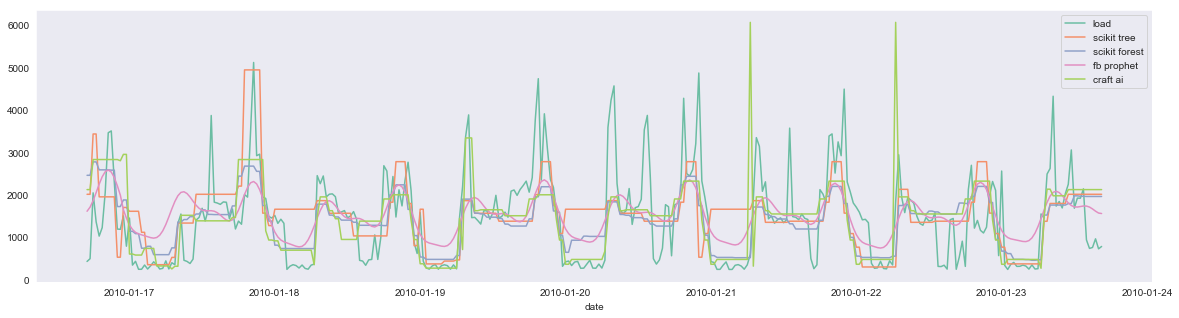

                  mae    mape    rmse        r2  week
ids                                                  
scikit tree    707.26  100.00  971.21  0.120951   111
scikit forest  593.03   71.46  818.06  0.376340   111
prophet        631.20   95.67  817.03  0.377904   111
craft ai       597.56   65.92  899.12  0.246609   111
scikit  computed
prophet computed
                  mae   mape     rmse        r2  week
ids                                                  
scikit tree    709.29  72.75  1042.40  0.227737   112
scikit forest  683.53  71.98  1020.95  0.259197   112
prophet        735.42  93.60  1033.29  0.241184   112
craft ai       729.22  79.07  1057.87  0.204659   112
scikit  computed
prophet computed
                  mae   mape    rmse        r2  week
ids                                                 
scikit tree    564.92  55.96  822.16  0.349205   113
scikit forest  571.83  58.18  821.57  0.350134   113
prophet        637.07  92.35  851.07  0.302636   113
craft ai       660.

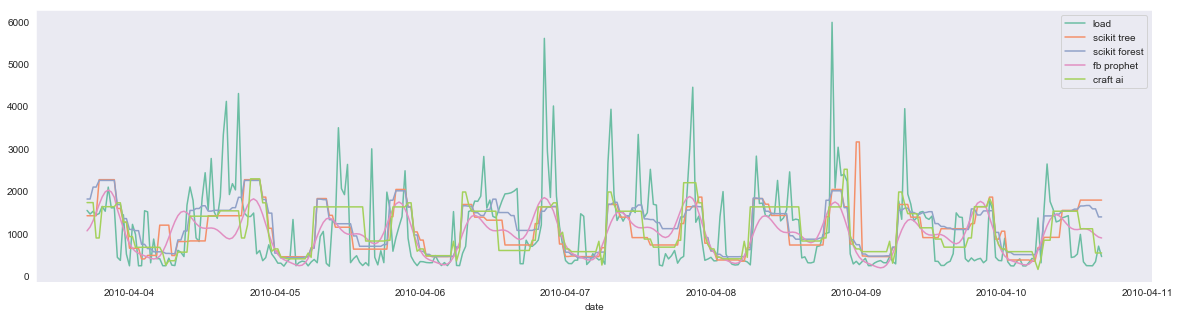

                  mae   mape    rmse        r2  week
ids                                                 
scikit tree    604.17  93.15  871.17  0.109164   122
scikit forest  558.06  91.74  795.82  0.256602   122
prophet        565.62  80.63  817.71  0.215146   122
craft ai       554.57  85.40  802.04  0.244926   122
scikit  computed
prophet computed
                  mae   mape    rmse        r2  week
ids                                                 
scikit tree    581.38  89.29  815.29  0.161405   123
scikit forest  534.05  83.07  760.75  0.269860   123
prophet        552.16  73.44  780.48  0.231489   123
craft ai       511.99  72.54  757.90  0.275306   123
scikit  computed
prophet computed
                  mae   mape    rmse        r2  week
ids                                                 
scikit tree    544.85  99.32  797.89 -0.222665   124
scikit forest  523.04  90.86  681.74  0.107396   124
prophet        518.90  80.61  687.91  0.091176   124
craft ai       530.16  92.82  7

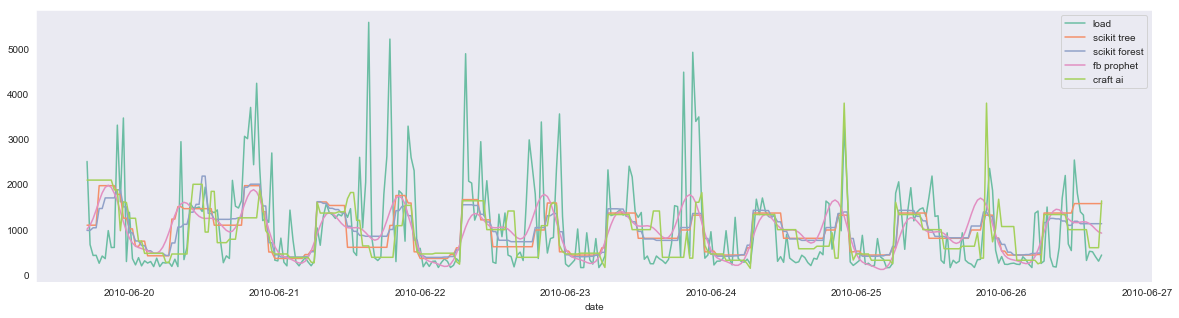

                  mae   mape    rmse        r2  week
ids                                                 
scikit tree    575.32  96.46  872.54  0.180316   133
scikit forest  554.70  92.62  829.96  0.258363   133
prophet        584.72  98.83  856.30  0.210536   133
craft ai       604.07  92.10  943.26  0.042061   133
scikit  computed
prophet computed
                  mae    mape    rmse        r2  week
ids                                                  
scikit tree    488.77   85.96  675.72 -0.101017   134
scikit forest  483.06   86.90  657.06 -0.041050   134
prophet        558.38  108.86  736.08 -0.306521   134
craft ai       551.43   98.06  769.74 -0.428736   134
scikit  computed
prophet computed
                  mae    mape    rmse        r2  week
ids                                                  
scikit tree    529.26   85.38  788.57 -0.317848   135
scikit forest  515.96   86.45  720.88 -0.101321   135
prophet        576.97  128.45  725.29 -0.114811   135
craft ai       587.8

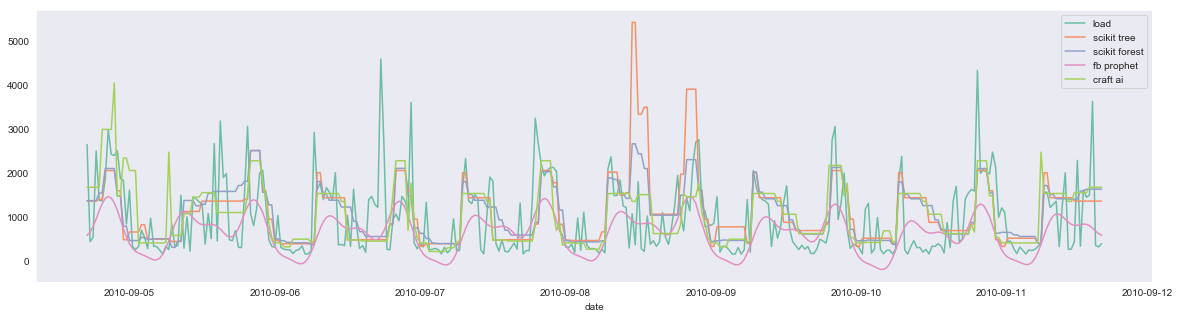

                  mae    mape    rmse        r2  week
ids                                                  
scikit tree    602.95  114.78  887.48 -0.154392   144
scikit forest  548.21  107.82  749.37  0.176944   144
prophet        564.91   80.11  781.23  0.105462   144
craft ai       560.61  103.63  776.72  0.115770   144
scikit  computed
prophet computed
                  mae    mape    rmse        r2  week
ids                                                  
scikit tree    610.04  132.63  871.28  0.053508   145
scikit forest  594.06  134.59  843.92  0.112017   145
prophet        610.94  113.91  886.61  0.019905   145
craft ai       643.61  144.25  917.68 -0.050009   145
scikit  computed
prophet computed
                  mae    mape    rmse        r2  week
ids                                                  
scikit tree    566.93  159.60  772.65  0.123127   146
scikit forest  554.06  162.97  752.46  0.168353   146
prophet        523.33  123.53  721.04  0.236354   146
craft ai      

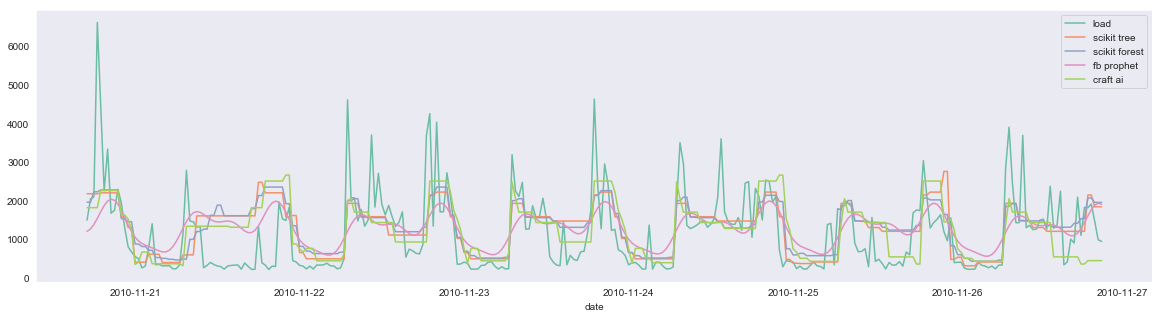

                  mae    mape    rmse        r2  week
ids                                                  
scikit tree    573.92   95.39  827.63  0.305197   155
scikit forest  588.65  105.75  821.52  0.315416   155
prophet        642.85  116.49  862.95  0.244639   155
craft ai       597.30   95.75  853.77  0.260620   155


In [82]:
#Let's start the predictions at the same time with craft :
start_pred = data.index.get_loc(pd.to_datetime('2009-11-28 17:00:00'))
week_index = int(start_pred/week_unit) # let's start the rolling preds for the last year
max_week_index = int(data.shape[0]/week_unit)
first_week_index = week_index
week_unit = 7*24*2

idx = ['scikit tree', 'scikit forest', 'prophet', 'craft ai']
scores = []
all_preds = []
# max_week_index
while week_index < max_week_index :
    last_train_index = start_pred + ( week_index - first_week_index) * week_unit
    last_test_index = last_train_index + week_unit
    week_preds = {}

    data_train, data_test = bt.split_data(data, last_train_index , last_test_index)

    sk_tree_preds = bt.get_scikit_preds(data_train, data_test, 10, exog = ['temperatureLow', 'temperatureHigh'])
    week_preds['scikit tree'] = sk_tree_preds

    forest_preds = bt.get_forest_preds(data_train, data_test, n_estimators=9, max_depth=9, exog = ['temperatureLow', 'temperatureHigh'])
    week_preds['scikit forest'] = forest_preds

    print('scikit  computed')

    #limit to one year of data to avoid memory error
    prophet_preds = bt.get_prophet_preds(data_train, data_test, exog = ['temperatureLow', 'temperatureHigh'], max_feed = 50*week_unit)

    week_preds['fb prophet'] = prophet_preds
    print('prophet computed')
#     try:
#         sarima_preds = bt.get_sarima_preds(data_train, data_test,week_unit, max_feed=3000)
#         week_preds['sarima'] = sarima_preds
#     except MemoryError:
#         print("Memory error for sarima preds on week", week_index)
#         sarima_preds = []
#         continue
    
     #compute craft ai preds 
    
    craft_preds_week = craft_preds.iloc[ (week_index - first_week_index)*week_unit : (week_index - first_week_index +1) * week_unit]
    crp = craft_preds_week['predictedLoad'].values
    week_preds['craft ai'] = crp
    
    #get scores for the current week
    frame = bt.get_models_scores(data_test=data_test,
                      predictions=[sk_tree_preds, forest_preds, prophet_preds, crp], 
                      idx =idx)
    frame['week'] = week_index +1 
    scores.append(frame)
    all_preds.append(week_preds)

    with open('scores_uci_res_bench.pickle', 'wb') as f:
        # Pickle the score array so that we can retrieve the scores if the prog fails
        pickle.dump(scores, f, pickle.HIGHEST_PROTOCOL)

    with open('preds_uci_res_dict.pickle', 'wb') as f:
        # Pickle the preds array so that we can plot and compare after 
        pickle.dump(all_preds, f, pickle.HIGHEST_PROTOCOL)

    #once in a while, print our predictions to see how they compare to each other and to the real values
    if (week_index%11 ==0):
        print("Model predictions for week n° {}".format(week_index+1))
        bt.plot_period_predictions(data_test=data_test.drop( ['temperatureLow', 'temperatureHigh'],1),
                                    predictions = week_preds)
    #print scores 
    print(frame)
    #update index
    week_index +=1

### Scores finaux 

In [31]:
with open('pickles/scores_uci_bench.pickle', 'rb' ) as f:
    scores = pickle.load(f)

In [32]:
# final_table = pd.concat([scores[0], craft_scores[0]],0)
# for i,score in enumerate(scores[1:50]):
#     final_table = pd.concat([final_table, score, craft_scores[i]],0)
# final_table = final_table.reset_index().set_index(['ids', 'week'])

In [103]:
final_table = scores[0]
for score in scores[1:]:
    final_table = pd.concat([final_table, score],0)
final_table = final_table.reset_index().set_index(['ids', 'week'])

In [104]:
final_table.groupby(by='ids').mean()

,mae,mape,rmse,r2
ids,,,,
craft ai,610.695769,95.995962,879.824615,-0.124927
prophet,620.374231,108.733269,837.068269,-0.060254
scikit forest,571.910577,96.655192,804.297308,0.077995
scikit tree,604.210385,99.548654,864.639231,-0.074318


After one year

In [105]:
#Après 1 an :
final_table.iloc[:6*25].groupby(by='ids').mean()

,mae,mape,rmse,r2
ids,,,,
craft ai,604.174324,90.816486,873.600270,-0.139779
prophet,615.493243,107.288108,830.529730,-0.064698
scikit forest,564.737368,90.447895,792.860789,0.063450
scikit tree,597.494211,93.070000,856.152632,-0.102219


After one year and a half

In [106]:
#Après 1 an et demi:
final_table.iloc[:6*50].groupby(by='ids').mean()

,mae,mape,rmse,r2
ids,,,,
craft ai,610.695769,95.995962,879.824615,-0.124927
prophet,620.374231,108.733269,837.068269,-0.060254
scikit forest,571.910577,96.655192,804.297308,0.077995
scikit tree,604.210385,99.548654,864.639231,-0.074318


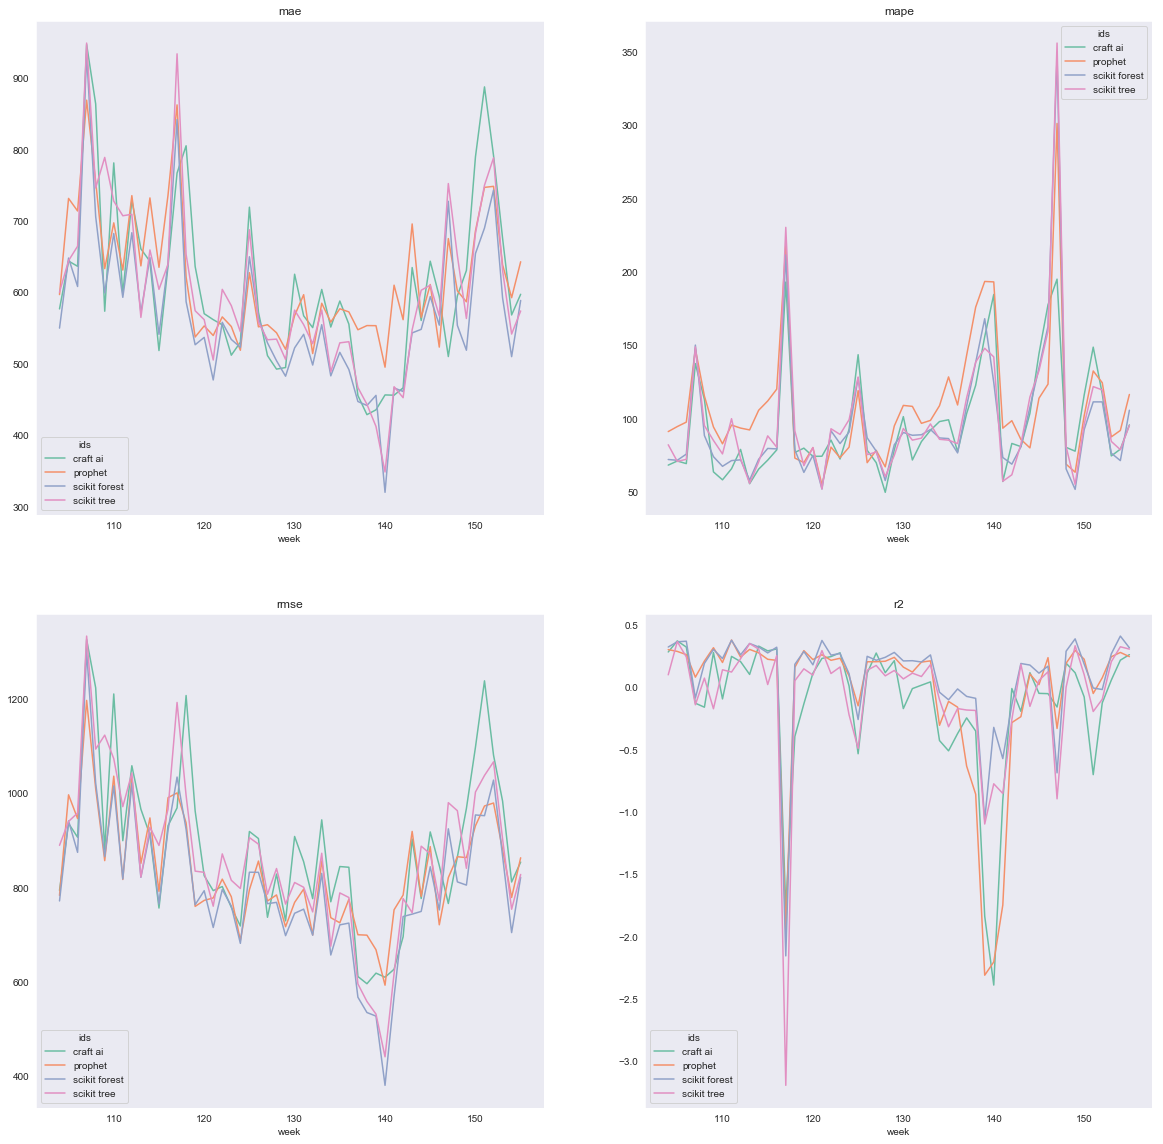

In [107]:
#printing the results 
fig, axes = plt.subplots(2,2, figsize=(20,20))
indexes = list(itertools.product(np.arange(0,2), np.arange(0,2)))
for i,metric in enumerate(final_table.columns):
    final_table.unstack()[metric].T.plot(ax = axes[indexes[i]])
    axes[indexes[i]].set_title(metric)
plt.show()

In [109]:
final_table.groupby(by='ids').describe()['r2']

,count,mean,std,min,25%,50%,75%,max
ids,,,,,,,,
craft ai,52.0,-0.124927,0.550543,-2.390273,-0.177724,0.011889,0.219668,0.370676
prophet,52.0,-0.060254,0.632762,-2.311171,-0.067010,0.203596,0.241753,0.377904
scikit forest,52.0,0.077995,0.425833,-2.156223,-0.015756,0.211057,0.286509,0.409487
scikit tree,52.0,-0.074318,0.546280,-3.194733,-0.172456,0.093418,0.175342,0.365109


In [111]:
final_table.groupby(by='ids').describe()['mape']

,count,mean,std,min,25%,50%,75%,max
ids,,,,,,,,
craft ai,52.0,95.995962,36.381595,49.85,72.3725,80.200,106.0025,195.04
prophet,52.0,108.733269,43.005800,54.92,82.3250,97.245,117.1500,301.10
scikit forest,52.0,96.655192,47.186854,51.85,72.3075,82.675,106.2675,347.03
scikit tree,52.0,99.548654,48.289791,52.14,75.8825,85.680,103.5550,355.85
